### Evaluating Solubility Prediction Using the General Solubility Equation with a Predicted Melting Point
This notebook tests the ability of the General Solbuility Equation (GSE) with a melting point model published by [Zhu](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00308) to predict the solubility data released as part of a recent paper by [Fang et al](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160) from Biogen.

In [1]:
import joblib
from xgboost import XGBRegressor
from rdkit import Chem
from rdkit.Chem import Crippen
from rdkit.Chem import Descriptors, rdMolDescriptors
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm
from plot_regression import plot_regression
import json

I had to do a bit of manipulation to get the CSD melting point model to load with newer versions of XGBoost.  The version of the model in the OpenSOL GitHub repo was created with XGBoost 1.5 (or earlier) and saved using joblib.  I ended up installing XGBoost 1.5 and saving the model as json.  The json version is compatible with more recent versions of XGBoost. 
<pre>
import joblib
model = joblib.load("xgboost_rdkit_2d_clustering_model.job")
model.save_model("xgboost_rdkit_2d_clustering_model.json")
</pre>

In [2]:
xgb = XGBRegressor()
xgb.load_model("xgboost_rdkit_2d_clustering_model.json")

In [3]:
ifs = open("rdkit_2022.09.3_descriptors.json")
desc_list = json.load(ifs)

This is the descriptor calculation code I borrowed from the [OpenSOL](https://github.com/sutropub/OpenSOL) github repo. 

In [4]:
def rdkit_2d_calc(mols, names=False, Autocorr2D=True):

    DescList = Descriptors.descList
    DscrNames = {}

    if Autocorr2D == True:
        DscrNames['Types'] = ['2D', 'Autocorr2D']
    else:
        DscrNames['Types'] = ['2D']

    DscrNames['Functions'] = {}

    for Type in DscrNames["Types"]:
        DscrNames[Type] = {}
        DscrNames[Type]["Names"] = []
        DscrNames["Functions"][Type] = []

    for Type in DscrNames['Types']:
        if Type == '2D':
            for dscr in DescList:
                DscrNames[Type]["Names"].append(dscr[0])
                DscrNames["Functions"][Type].append(dscr[1])
        elif Type == 'Autocorr2D':
            # The current rdkit has 192 Autocorr2D descriptors as of 04_14_2022
            COUNT = 192
            DscrNames[Type]["Names"] = ['Autocorr2D_{}'.format(i) for i in range(COUNT)]
            DscrNames["Functions"][Type] = rdMolDescriptors.CalcAUTOCORR2D

    dscr_names = Names_generator(DscrNames)

    if names:
        assert len(mols) == len(names)
        idx = names
    else:
        idx = list(range(len(mols)))

    df_dscr = pd.DataFrame(np.nan, index=idx, columns=dscr_names)

    for mol, name in tqdm(zip(mols, idx),total=len(df_dscr)):
        if mol:
            df_dscr.loc[name] = Values_generator(mol, DscrNames)

    return(df_dscr)

def Names_generator(DscrNames):
    dscr_names = []
    for Type in DscrNames['Types']:
        for Name in DscrNames[Type]['Names']:
            dscr_names.append(Name)
    return dscr_names

def Values_generator(mol, DscrNames):
    dscr_values = []
    for Type in DscrNames['Types']:
        if Type in ['2D', '3D']:
            for Function in DscrNames['Functions'][Type]:
                dscr_values.append(Function(mol))
        else:
            dscr_values.extend(DscrNames['Functions'][Type](mol))
    return dscr_values

def clogP_calc(mols):
    clogp = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        clogp.append(Crippen.MolLogP(mol))
    return clogp

Read the Biogen solubility dataset (BSD)

In [5]:
df = pd.read_csv("biogen_solubility.csv")

Add a molecule column to the dataframe

In [6]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Calcluate the molecular descriptors

In [7]:
desc_df = rdkit_2d_calc(df.mol.values,Autocorr2D=False)

  0%|          | 0/2173 [00:00<?, ?it/s]

Predict the melting point and add the predicted melting point to the dataframe

This is a bit of a hack to make sure desc_df only contains the descriptors that were avialable in the 2022.09 version of the RDKit.  Is is the version that was used to train the model. 

In [8]:
desc_df = desc_df[desc_list]

In [9]:
df['mp'] = xgb.predict(np.stack(desc_df.to_numpy()))

Calculate CLogP for the molecules in the dataframe

In [10]:
df['clogp'] = clogP_calc(df.mol.values)

Calculate solubility using the GSE

In [11]:
df['pred_sol'] = 0.5 - 0.01 * (df.mp - 25 - 273.15) - df.clogp

Plot the model performance

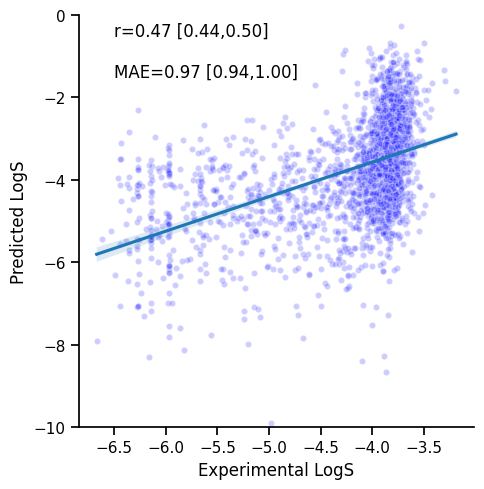

In [12]:
plot_regression(df.logS,df.pred_sol)

In [13]:
df['GSE_residuals'] = df.logS - df.pred_sol

In [14]:
df.head(2)

,Internal ID,Vendor ID,SMILES,logS,mol,mp,clogp,pred_sol,GSE_residuals
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-5.548020,<rdkit.Chem.rdchem.Mol object at 0x7faf89964a50>,510.062836,1.9007,-3.519828,-2.028191
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.071409,<rdkit.Chem.rdchem.Mol object at 0x7faf89964ac0>,422.837921,4.1809,-4.927779,-0.143630


In [15]:
df[['Internal ID','Vendor ID','SMILES','GSE_residuals']].to_csv("GSE_residuals.csv",index=False)

Approximate the impact of errors in melting point and LogP on predictions using the GSE.  Let's assume the GSE generates perfect predictions.  What's the impact of a 30 degree error in melting point?  Let's assume that the GSE is a perfect predictor and examine the impact of the error. 

In [16]:
test_vals = df[['mp','clogp']].values

The error from melting point alone

In [17]:
mp_sd = 30.0
delta_list = []
for i in range(0,1000):
    i = np.random.choice(range(0,len(df)))
    mp, clogp = test_vals[i]
    logS_true = 0.5 - 0.01 * (mp - 25 - 273.15) - clogp
    mp_err = np.random.normal(0,mp_sd)
    logS_err = 0.5 - 0.01 * (mp+mp_err - 25 - 273.15) - clogp
    delta_list.append(abs(logS_true - logS_err))
np.mean(delta_list)

0.23958300079423575

The error from CLogP

In [18]:
clogp_sd = 0.677
delta_list = []
for i in range(0,1000):
    i = np.random.choice(range(0,len(df)))
    mp, clogp = test_vals[i]
    logS_true = 0.5 - 0.01 * (mp - 25 - 273.15) - clogp
    clogp_err = np.random.normal(0,clogp_sd)
    logS_err = 0.5 - 0.01 * (mp - 25 - 273.15) - clogp + clogp_err
    delta_list.append(abs(logS_true - logS_err))
np.mean(delta_list)

0.5285247834266875

The error from the combination of melting point and CLogP

In [19]:
delta_list = []
for i in range(0,1000):
    i = np.random.choice(range(0,len(df)))
    mp, clogp = test_vals[i]
    logS_true = 0.5 - 0.01 * (mp - 25 - 273.15) - clogp
    mp_err = np.random.normal(0,mp_sd)
    clogp_err = np.random.normal(0,clogp_sd)
    logS_err = 0.5 - 0.01 * (mp + mp_err - 25 - 273.15) - clogp + clogp_err
    delta_list.append(abs(logS_true - logS_err))
np.mean(delta_list)

0.6145477452950993